In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import shutil
from tqdm import tqdm

In [16]:
# http://ai.stanford.edu.ezproxy2.utwente.nl/~jkrause/cars/car_dataset.html

In [17]:
def load_dataset(path):
    training_labels = scipy.io.loadmat(path)
    res = [np.array([bbox_x1, bbox_y1, bbox_x2, bbox_y2, label, file_name], dtype='object').reshape(-1) 
           for bbox_x1, bbox_y1, bbox_x2, bbox_y2, label, file_name in training_labels['annotations'][0]]
    return np.asarray(res) # Returns bbox_x1, bbox_y1, bbox_x2, bbox_y2, label, file_name

def load_labels(path):
    mat = scipy.io.loadmat(path)
    class_names = [l[0] for l in mat['class_names'][0,:]]
    # How stupid that the class indices start with 1... 
    # Replace the '/' for when creating structure 
    label_map = {idx+1: name.replace('/', '_') for idx, name in enumerate(class_names)}
    return label_map # {class_index: label}

def lookup_class_idx_by_file_name(dataset, file_name):
    idx = np.where(dataset[:, 5]==file_name) # Do lookup by file_name
    class_idx = dataset[idx, 4]
    return class_idx[0,0]

### Paths
To use this notebooks correctly adjust the paths below to your corresponding directories:

from `http://ai.stanford.edu.ezproxy2.utwente.nl/~jkrause/cars/car_dataset.html` download the:
- <b>cars_train</b> (training images)
- <b>cars_test</b> (testing images)
- <b>annotations</b> (devkit + test annotations, the test annotation can be downloaded from the 'update' paragraph)

File structure you need to create must look like: 
```
data
│   
└───StanfordCars
    │
    └───cars_train
    │    +   [training_images...]
    └───cars_test
    │    +   [testing_images...]
    └───annotations
         +  cars_train_annos.mat
         +  cars_test_annos_withlabels.mat
         +  cars_meta.mat
```

In [ ]:
global_path = '../data/StanfordCars'
training_imgs_path = global_path+'/cars_train'
testing_imgs_path = global_path+'/cars_test'

training_dataset = load_dataset(global_path+'/annotations/cars_train_annos.mat')
testing_dataset = load_dataset(global_path+'/annotations/cars_test_annos_withlabels.mat')
label_map= load_labels(global_path+'/annotations/cars_meta.mat')

In [ ]:
# Create structure for loading into PyTorch Dataset model
folder_name = 'pytorch_structured_dataset'
folder_path = os.path.join(global_path, folder_name)
def mkdir_if_not_exists(dirpath):
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)

mkdir_if_not_exists(folder_path)
for subfolder_name in ['train', 'val']:
    subfolder_path = os.path.join(folder_path, subfolder_name)
    mkdir_if_not_exists(subfolder_path)
    for label in label_map.values():
        mkdir_if_not_exists(os.path.join(subfolder_path, label))

In [ ]:
# Put all the training images into every directory
imgs_path = {
    'train': training_imgs_path,
    'val': testing_imgs_path
}
dataset = {
    'train': training_dataset,
    'val': testing_dataset
}
for subfolder_name in ['train', 'val']:

    for img_path in tqdm(os.listdir(imgs_path[subfolder_name])):
        # print(training_imgs_path+'/'+img_path)
        # Get class by looking up file_name
        img_class_idx = lookup_class_idx_by_file_name(dataset[subfolder_name], img_path)
        img_class_label = label_map[img_class_idx]

        src = os.path.join(imgs_path[subfolder_name], img_path)
        dst = os.path.join(global_path, folder_name, subfolder_name, img_class_label, img_path)
        # dst = global_path+'/'+folder_name+'/train/'+img_class_label+'/'+img_path
        shutil.copyfile(src, dst)

In [25]:
# Put all the training images into every directory
imgs_path = {
    'train': training_imgs_path,
    'val': testing_imgs_path
}
dataset = {
    'train': training_dataset,
    'val': testing_dataset
}
for subfolder_name in ['train', 'val']:

    for img_path in tqdm(os.listdir(imgs_path[subfolder_name])):
        # print(training_imgs_path+'/'+img_path)
        # Get class by looking up file_name
        img_class_idx = lookup_class_idx_by_file_name(training_dataset, img_path)
        img_class_label = label_map[img_class_idx]

        src = os.path.join(imgs_path[subfolder_name], img_path)
        dst = os.path.join(global_path, folder_name, subfolder_name, img_class_label, img_path)
        # dst = global_path+'/'+folder_name+'/train/'+img_class_label+'/'+img_path
        shutil.copyfile(src, dst)

100%|██████████| 8041/8041 [00:09<00:00, 861.17it/s] 


<BarContainer object of 196 artists>

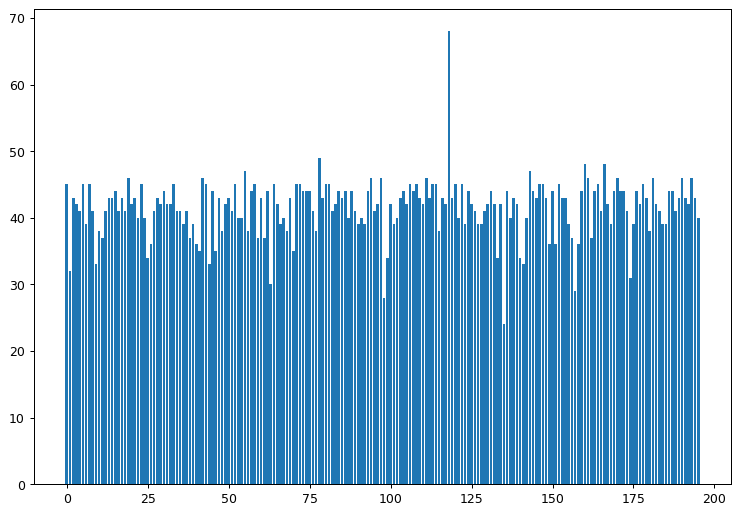

In [26]:
# Distributions of the classes
unique, counts = np.unique(training_dataset[:, 4], return_counts=True)
plt.figure(figsize=(10, 7), dpi=90)
plt.bar(range(0, len(counts)), counts)